2021-08-20 10:03:03,953 - INFO - ['S14-23323-3Q-HIGH', 'S14-10290-3S-INT', 'S15-16071-3O-high', 'S14-06803-MG1-HIGH', 'S15-20879-3N-high']
2021-08-20 10:03:03,953 - INFO - ['S14-23323-3Q-HIGH', 'S14-10290-3S-INT', 'S15-16071-3O-high', 'S14-06803-MG1-HIGH', 'S15-20879-3N-high']
2021-08-20 10:03:03,953 - INFO - ['S14-23323-3Q-HIGH', 'S14-10290-3S-INT', 'S15-16071-3O-high', 'S14-06803-MG1-HIGH', 'S15-20879-3N-high']
2021-08-20 10:03:03,953 - INFO - ['S14-23323-3Q-HIGH', 'S14-10290-3S-INT', 'S15-16071-3O-high', 'S14-06803-MG1-HIGH', 'S15-20879-3N-high']
2021-08-20 10:03:03,953 - INFO - ['S14-23323-3Q-HIGH', 'S14-10290-3S-INT', 'S15-16071-3O-high', 'S14-06803-MG1-HIGH', 'S15-20879-3N-high']
2021-08-20 10:03:04,276 - INFO - file_name : S14-06803-MG1-HIGH
2021-08-20 10:03:04,276 - INFO - file_name : S14-06803-MG1-HIGH
2021-08-20 10:03:04,276 - INFO - file_name : S14-06803-MG1-HIGH
2021-08-20 10:03:04,276 - INFO - file_name : S14-06803-MG1-HIGH
2021-08-20 10:03:04,276 - INFO - file_name : S14-

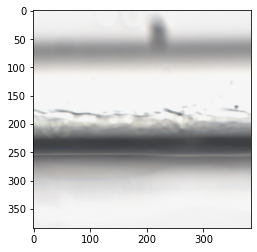

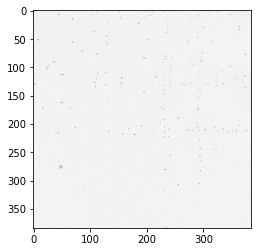

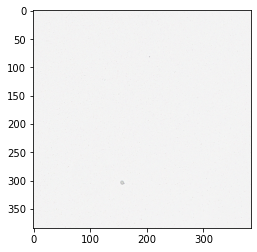

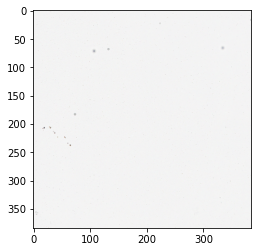

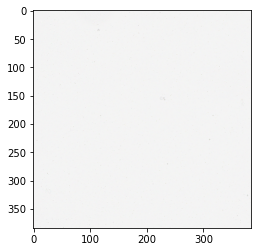

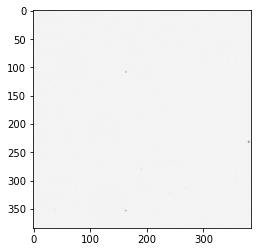

KeyboardInterrupt: 

In [12]:
import argparse
import glob
import os
import pathlib
import logging

from PIL import Image

import cv2
import numpy as np
import openslide
import torch
import torch.nn as nn

import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from tifffile import memmap

import staintools

import pickle

def load_model(pretrained):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(in_features=512, out_features=9, bias=True)
    return model


def isBG(Img, BG_Thres, BG_Percent):
    Gray_Img = np.uint8(rgb2gray(Img) * 255)
    White_Percent = np.mean((Gray_Img > BG_Thres))
    Black_Percent = np.mean((Gray_Img < 255 - BG_Thres))

    if Black_Percent > BG_Percent or White_Percent > BG_Percent or Black_Percent + White_Percent > BG_Percent:
        return True
    else:
        return False
    
def PercentBackground(image, threshold):
    gray_scale = rgb2gray(image)
    binary = np.mean(gray_scale > threshold)
    
    return binary 

def get_region(grid_x, image_w, grid_w, margin_w):
    '''
    Return the base and offset pair to read from the image.
    :param grid_x: grid index on the image
    :param image_w: image width (or height)
    :param grid_w: grid width (or height)
    :param margin: margin width (or height)

    :return: the base index and the width on the image to read
    '''
    image_x = grid_x * grid_w

    image_l = min(image_x, image_w - grid_w)
    image_r = image_l + grid_w - 1

    read_l = max(0, image_l - margin_w)
    read_r = min(image_r + margin, image_w - 1)
    #    read_l = min(image_x - margin_w, image_w - (grid_w + margin_w))
    #    read_r = min(read_l + grid_w + (margin_w << 1), image_w) - 1
    #    image_l = max(0,read_l + margin_w)
    #    image_r = min(image_l + grid_w , image_w) - 1
    return read_l, image_l, image_r, read_r


def resize_region(im_l, im_r, scale_factor):
    sl = im_l // scale_factor
    sw = (im_r - im_l + 1) // scale_factor
    sr = sl + sw - 1
    return sl, sr




# In[4]:


patch_size = 3072

run_info = 'test_{}'.format(patch_size)

if not os.path.exists('checkpoints/{}'.format(run_info)):
    os.mkdir('checkpoints/{}'.format(run_info))

log = logging.getLogger('staining_log')
log.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
fileHandler = logging.FileHandler('checkpoints/{}/log.txt'.format(run_info))
streamHandler = logging.StreamHandler()
fileHandler.setFormatter(formatter)
streamHandler.setFormatter(formatter)
#
log.addHandler(fileHandler)
log.addHandler(streamHandler)







#patch_size = 3072
all_patient_name = [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-1/*.pickle'.format(patch_size)))] +                    [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-2/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-3/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-4/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-5/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-6/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-7/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-8/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-9/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-10/*.pickle'.format(patch_size)))]






######### Shuffle ########
all_patient_name = np.array(all_patient_name)
np.random.seed(777)
np.random.shuffle(all_patient_name)
all_patient_name = all_patient_name.tolist()
######### Shuffle ########


    
len_ = len(all_patient_name)
idx = int(len_*0.8)
    
train_patient = all_patient_name[:idx]
val_patient = all_patient_name[idx:]




val_patient = ['S14-23323-3Q-HIGH',
 'S14-10290-3S-INT',
 'S15-16071-3O-high',
 'S14-06803-MG1-HIGH',
 'S15-20879-3N-high',
 'S14-06865-3V-HIGH',
 'S14-22616-3Q-int',
 'S14-29271-3U-high',
 'S14-10254-3S-HIGH',
 'S14-31341-3U-int',
 'S15-18168-3N-high',
 'S15-17795-3P-high',
 'S15-28817-8Z-low',
 'S14-42815-3P-high',
 'S15-925-3Z-low',
 'S15-17899-3T-high',
 'S14-15292-3P-INT']



log.info(val_patient[:5])


all_svs_path = glob.glob('../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page*/*.svs')


val_idx = np.isin(np.array([i.split('/')[-1].split('.')[0] for i in all_svs_path]), np.array(val_patient))
val_svs_path = np.array(all_svs_path)[val_idx].tolist()

val_svs_path = sorted(val_svs_path)

val_svs_path[:5]












device = 'cpu'


model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2, bias=True)


model.to(device)
model.eval()














output_file_path = 'result_npy/{}'.format(patch_size)
if not os.path.exists(output_file_path):
    os.mkdir(output_file_path) 

    
temp = [i.split('/')[-1].split('.')[0] for i in val_svs_path]
    
for i in range(len(val_svs_path)):
    
    log.info("file_name : {}".format(temp[i]))
    log.info('path : {}'.format(val_svs_path[i]))
    
    HE_SLIDE = openslide.open_slide(val_svs_path[i])
    slide_width, slide_height = HE_SLIDE.dimensions
    
    
    overlab = 2
    local_size = int(patch_size / overlab)
    
    
    num_w = slide_width // local_size
    num_h = slide_height // local_size
    
    A = np.ones((num_w, num_h))  #
    iter_list = [[i[0][0],
                    i[0][1]
                    ] for i in np.ndenumerate(A)]  #
    len_itr = len(iter_list)
    tsp_map = np.zeros((num_h, num_w))
        
        
    down_scale = 32
    original_npy = np.zeros(shape=(int(slide_height/down_scale) , int(slide_width/down_scale), 2))
    log.info('Width : {} Height : {}'.format(int(slide_width/down_scale), int(slide_height/down_scale)))
    #down_npy = np.zeros(shape=(num_h, num_w))
            
    for idx, (x, y) in enumerate(iter_list):
        
        
        HE_patch_raw = HE_SLIDE.read_region((x*patch_size, y*patch_size), 0, (local_size, local_size))
        HE_patch_raw = np.array(HE_patch_raw)[:,:,:3]
        HE_patch_raw = cv2.resize(HE_patch_raw, None, fx=0.25, fy=0.25)
        
        plt.imshow(HE_patch_raw)
        plt.show()

In [11]:
num_w, num_h

(33, 30)

In [13]:
num_w, num_h

(67, 60)